<a href="https://colab.research.google.com/github/miltiadiss/Decision-Theory/blob/main/Project%202/Counterfeiting_of_banknotes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Decision Theory**

#**Project 2: Counterfeiting of banknotes**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**Load data and apply Z-Score Normalization on features**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data from csv
file_path = '/content/drive/MyDrive/data.csv'
data = pd.read_csv(file_path)

# Separate features (X) and target variable (y)
X = data.drop(columns=['class']) # Drop only column 'class' to keep the features
y = data['class'] # Keep only column 'class' which is the target

# Apply Z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns) # Convert the scaled data into a DataFrame

##**Question 1**

###**PCA**


Principal Components:
     variance  skewness  curtosis   entropy
PC1  0.248772  0.639323 -0.612707 -0.392389
PC2  0.754591 -0.050340 -0.153459  0.636010


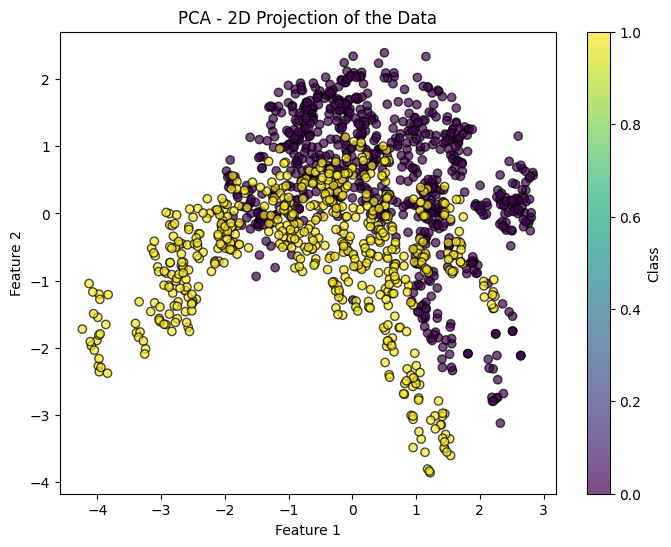

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce the number of features to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)

# Convert the PCA result into a DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Split the data into 60% training, 20% validation, and 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X_pca_df, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Display the contribution of each feature to each principal component
print("\nPrincipal Components:")
components_df = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2'])
print(components_df)

# Plot the PCA features
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(label='Class')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('PCA - 2D Projection of the Data')
plt.show()

###**Parzen Windows**

Bandwidth: 0.1, Training Accuracy: 0.9247, Validation Accuracy: 0.8613
Bandwidth: 0.5, Training Accuracy: 0.8165, Validation Accuracy: 0.8102
Bandwidth: 1.0, Training Accuracy: 0.7922, Validation Accuracy: 0.7883
Bandwidth: 2.0, Training Accuracy: 0.7618, Validation Accuracy: 0.7774
Bandwidth: 5.0, Training Accuracy: 0.7618, Validation Accuracy: 0.7774


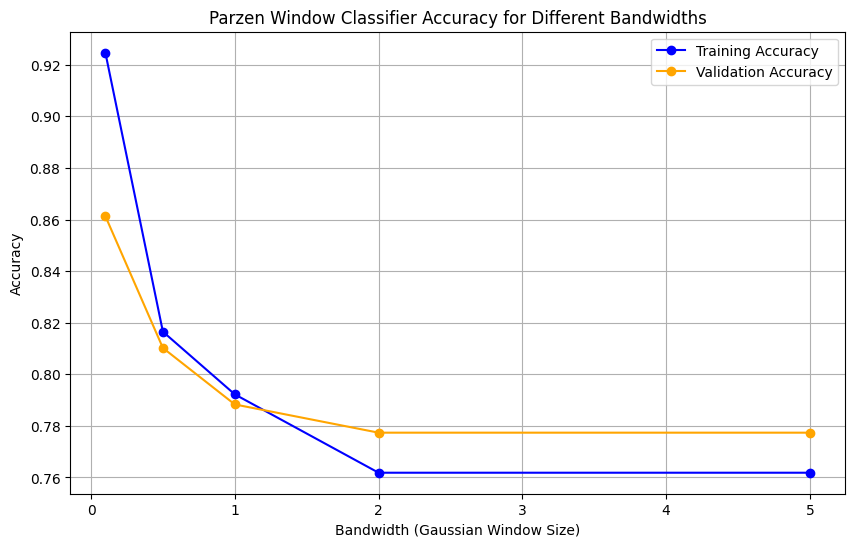

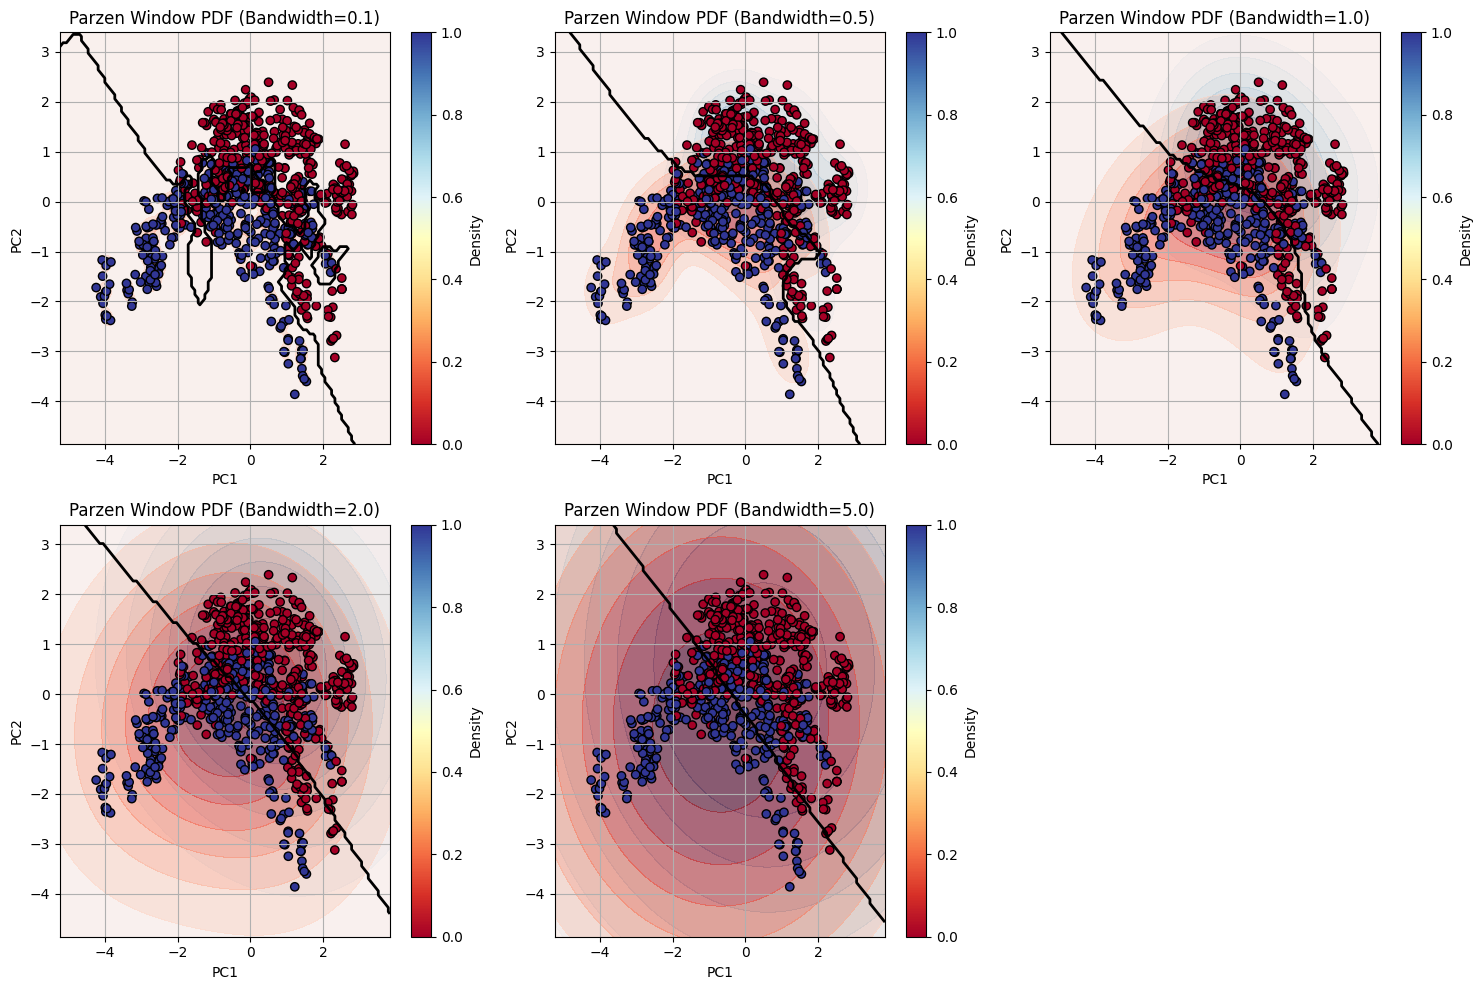

In [5]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parzen Window with Gaussian Kernel
def parzen_window(X_train, y_train, X_test, bandwidth):
    classes = np.unique(y_train)
    predictions = []

    for x_test in X_test.values:
        class_probabilities = []

        for c in classes:
            # Get the training data for the current class
            X_class = X_train[y_train == c]

            # Compute the Parzen window density estimate for the current class
            density = 0
            for x_train in X_class.values:
                # Gaussian kernel
                density += np.exp(-np.linalg.norm(x_test - x_train) ** 2 / (2 * bandwidth ** 2))

            # Normalize the density
            density /= len(X_class)
            class_probabilities.append(density)

        # Classify based on the highest density estimate
        predicted_class = classes[np.argmax(class_probabilities)]
        predictions.append(predicted_class)

    return np.array(predictions)

# Parzen Window with Gaussian Kernel for PDF estimation
def parzen_window_pdf(X_train, y_train, X_test, bandwidth):
    classes = np.unique(y_train)
    pdfs = {c: [] for c in classes}  # Dictionary to store PDFs for each class

    # For each test point, compute the density estimate for each class
    for x_test in X_test.values:
        for c in classes:
            # Get the training data for the current class
            X_class = X_train[y_train == c]

            # Compute the Parzen window density estimate for the current class
            density = 0
            for x_train in X_class.values:
                # Gaussian kernel
                density += np.exp(-np.linalg.norm(x_test - x_train) ** 2 / (2 * bandwidth ** 2))

            # Normalize the density
            density /= len(X_class)
            pdfs[c].append(density)

    return pdfs

# Generate a grid of points for plotting
x_min, x_max = X_train['PC1'].min() - 1, X_train['PC1'].max() + 1
y_min, y_max = X_train['PC2'].min() - 1, X_train['PC2'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Bandwidths to evaluate
bandwidths = [0.1, 0.5, 1.0, 2.0, 5.0]

# Store accuracies for training and validation sets
train_accuracies = []
val_accuracies = []

for bandwidth in bandwidths:
    # Predict on training set
    y_train_pred = parzen_window(X_train, y_train, X_train, bandwidth)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Predict on validation set
    y_val_pred = parzen_window(X_train, y_train, X_val, bandwidth)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(val_accuracy)

    print(f"Bandwidth: {bandwidth}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(bandwidths, train_accuracies, marker='o', linestyle='-', label='Training Accuracy', color='blue')
plt.plot(bandwidths, val_accuracies, marker='o', linestyle='-', label='Validation Accuracy', color='orange')
plt.xlabel('Bandwidth (Gaussian Window Size)')
plt.ylabel('Accuracy')
plt.title('Parzen Window Classifier Accuracy for Different Bandwidths')
plt.legend()
plt.grid(True)
plt.show()

# Plot PDFs for each bandwidth on a grid
plt.figure(figsize=(15, 10))
for bandwidth in bandwidths:
    pdfs = parzen_window_pdf(X_train, y_train, pd.DataFrame(grid_points, columns=['PC1', 'PC2']), bandwidth)
    Z_class_0 = np.array(pdfs[0]).reshape(xx.shape)
    Z_class_1 = np.array(pdfs[1]).reshape(xx.shape)

    plt.subplot(2, 3, bandwidths.index(bandwidth) + 1)
    plt.contourf(xx, yy, Z_class_0, alpha=0.5, cmap='Blues')
    plt.contourf(xx, yy, Z_class_1, alpha=0.5, cmap='Reds')

    # Plot decision boundaries
    decision_boundaries = parzen_window(X_train, y_train, pd.DataFrame(grid_points, columns=['PC1', 'PC2']), bandwidth)
    decision_boundaries = decision_boundaries.reshape(xx.shape)
    plt.contour(xx, yy, decision_boundaries, levels=[0.5], linewidths=2, colors='black')

    # Plot training data points
    plt.scatter(X_train['PC1'], X_train['PC2'], c=y_train, cmap=plt.cm.RdYlBu, edgecolors='k', marker='o')

    plt.title(f'Parzen Window PDF (Bandwidth={bandwidth})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(label='Density')
    plt.grid(True)

plt.tight_layout()
plt.show()

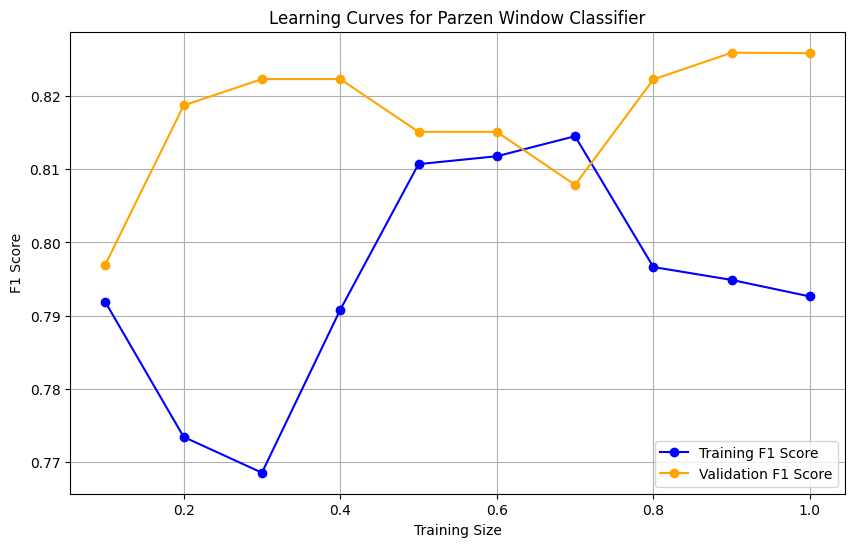

F1 Score for Parzen Window: 0.8259


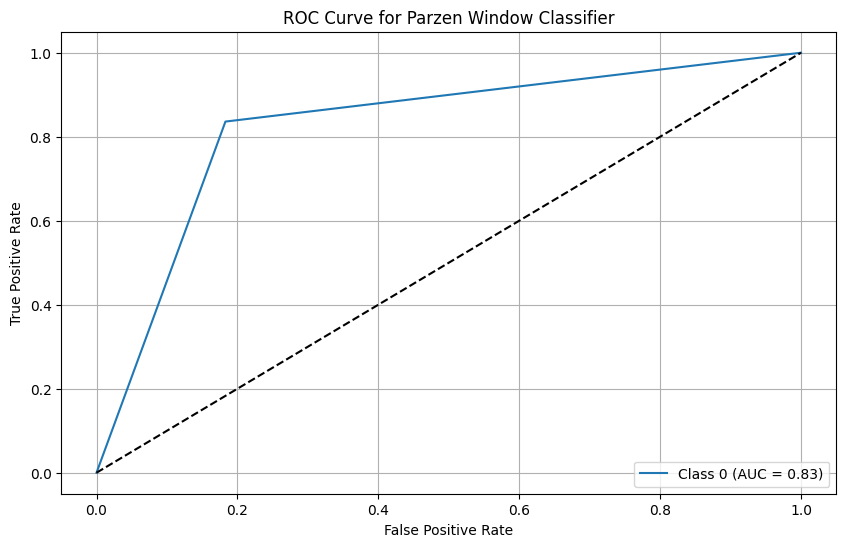

Average AUC for Parzen Window: 0.8265


In [16]:
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Function to generate learning curve data for Parzen Window classifier
def generate_learning_curve(X_train, y_train, X_test, y_test, bandwidth, step=0.1):
    train_sizes = np.linspace(0.1, 1.0, 10)  # Training sizes from 10% to 100%
    train_f1_scores = []
    val_f1_scores = []

    # Loop over each training size
    for train_size in train_sizes:
        # Calculate the number of samples for the current train_size
        num_train_samples = int(train_size * len(X_train))

        # Subset the training data
        X_train_subset = X_train[:num_train_samples]
        y_train_subset = y_train[:num_train_samples]

        # Train the Parzen window classifier on the current subset of training data
        y_train_pred = parzen_window(X_train_subset, y_train_subset, X_train_subset, bandwidth)
        train_f1 = f1_score(y_train_subset, y_train_pred, average='weighted')
        train_f1_scores.append(train_f1)

        # Validate on the full test set
        y_val_pred = parzen_window(X_train_subset, y_train_subset, X_test, bandwidth)
        val_f1 = f1_score(y_test, y_val_pred, average='weighted')
        val_f1_scores.append(val_f1)

    return train_sizes, train_f1_scores, val_f1_scores

# Set the optimal bandwidth (h=1.0)
bandwidth = 1.0

# Generate learning curves
train_sizes, train_f1_scores, val_f1_scores = generate_learning_curve(X_train, y_train, X_test, y_test, bandwidth)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_f1_scores, marker='o', label='Training F1 Score', color='blue')
plt.plot(train_sizes, val_f1_scores, marker='o', label='Validation F1 Score', color='orange')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.title('Learning Curves for Parzen Window Classifier')
plt.legend()
plt.grid(True)
plt.show()

# Use the Parzen window classifier with the optimal bandwidth h=1.0 to make the prediction
y_pred = parzen_window(X_train, y_train, X_test, bandwidth)

# Calculate the F1 score for the test set
f1_parzen = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score for Parzen Window: {f1_parzen:.4f}")

# ROC and AUC calculations
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))  # Binary encoding of the labels
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_train))

# Calculate ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plotting the chance level
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Parzen Window Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display the AUC score
average_auc = np.mean(list(roc_auc.values()))
print(f"Average AUC for Parzen Window: {average_auc:.4f}")

An **AUC of 0.83 is a strong result**, meaning that **the Parzen Window Classifier can distinguish Class 0 from Class 1 most of the time**. The steep rise at the start of the ROC curve indicates that the classifier achieves a high True Positive Rate (TPR) for Class 0 at a low False Positive Rate (FPR). This shows good discrimination of the 2 classes in general. However, the middle part of the curve might show some overlap between the classes, where the classifier struggles to distinguish between Class 0 and Class 1 for certain instances.

##**Question 2**

##**k-NN**

k: 1, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
k: 3, Training Accuracy: 0.9976, Validation Accuracy: 1.0000
k: 5, Training Accuracy: 0.9976, Validation Accuracy: 1.0000
k: 7, Training Accuracy: 0.9976, Validation Accuracy: 1.0000
k: 9, Training Accuracy: 0.9976, Validation Accuracy: 1.0000
k: 11, Training Accuracy: 0.9927, Validation Accuracy: 1.0000
k: 15, Training Accuracy: 0.9915, Validation Accuracy: 0.9891
k: 20, Training Accuracy: 0.9915, Validation Accuracy: 0.9891
k: 25, Training Accuracy: 0.9891, Validation Accuracy: 0.9891
k: 28, Training Accuracy: 0.9891, Validation Accuracy: 0.9891
k: 30, Training Accuracy: 0.9891, Validation Accuracy: 0.9891


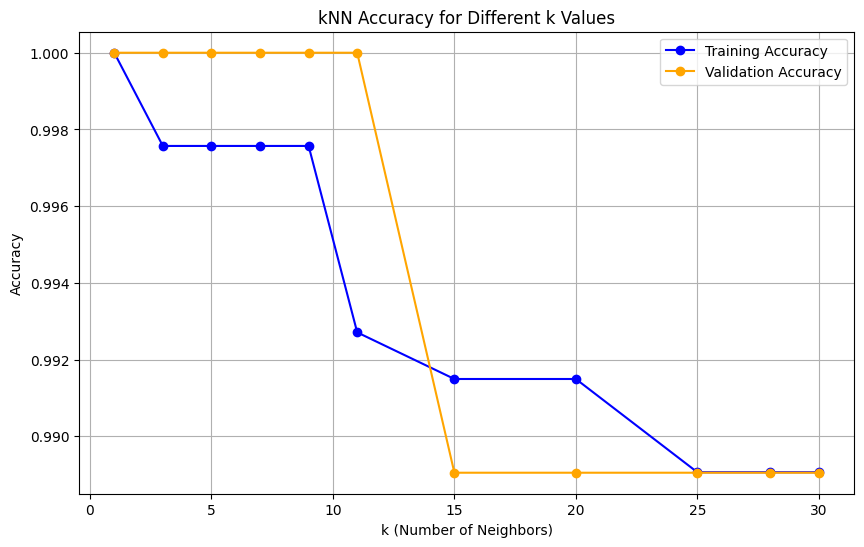

In [25]:
from sklearn.neighbors import KNeighborsClassifier

# Split data into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled_df, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Test kNN for different values of k
k_values = [1, 3, 5, 7, 9, 11, 15, 20, 25, 28, 30]
training_accuracies = []
validation_accuracies = []

for k in k_values:
    # Create and train the kNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predict on training and validation sets
    y_train_pred = knn.predict(X_train)
    y_val_pred = knn.predict(X_val)

    # Calculate accuracy for training and validation sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Store the accuracies
    training_accuracies.append(train_accuracy)
    validation_accuracies.append(val_accuracy)

    # Print accuracy for this k
    print(f"k: {k}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(k_values, training_accuracies, label='Training Accuracy', marker='o', linestyle='-', color='blue')
plt.plot(k_values, validation_accuracies, label='Validation Accuracy', marker='o', linestyle='-', color='orange')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('kNN Accuracy for Different k Values')
plt.legend()
plt.grid(True)
plt.show()

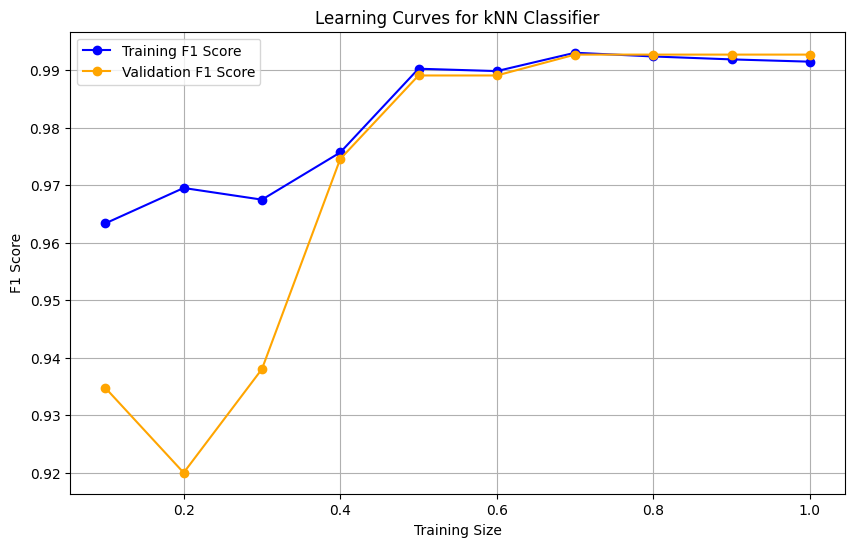

F1 Score for k-NN: 0.9927


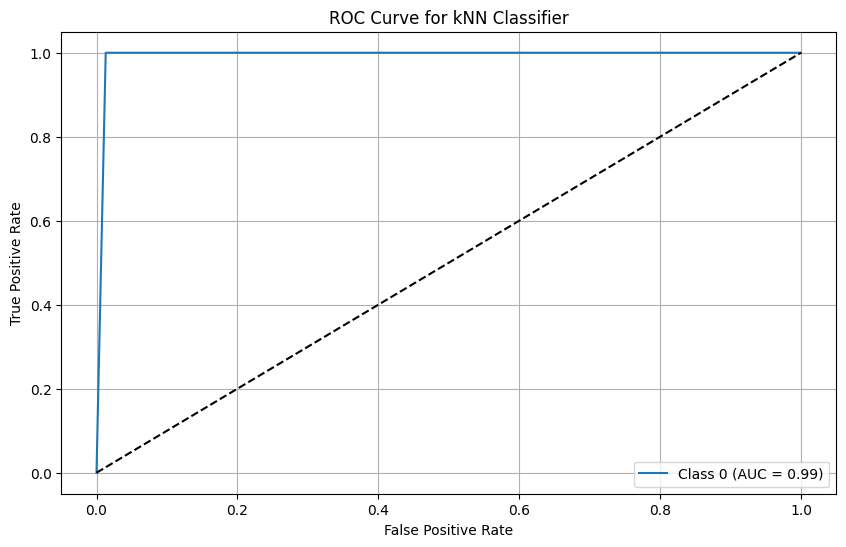

Average AUC for kNN: 0.9935


In [32]:
# Function to generate learning curve data for kNN classifier
def generate_learning_curve_knn(X_train, y_train, X_test, y_test, k=3, step=0.1):
    train_sizes = np.linspace(0.1, 1.0, 10)  # Training sizes from 10% to 100%
    train_f1_scores = []
    val_f1_scores = []

    # Loop over each training size
    for train_size in train_sizes:
        # Calculate the number of samples for the current train_size
        num_train_samples = int(train_size * len(X_train))

        # Subset the training data
        X_train_subset = X_train[:num_train_samples]
        y_train_subset = y_train[:num_train_samples]

        # Train the kNN classifier on the current subset of training data
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_subset, y_train_subset)

        # Predict on the training set
        y_train_pred = knn.predict(X_train_subset)
        train_f1 = f1_score(y_train_subset, y_train_pred, average='weighted')
        train_f1_scores.append(train_f1)

        # Predict on the test set
        y_val_pred = knn.predict(X_test)
        val_f1 = f1_score(y_test, y_val_pred, average='weighted')
        val_f1_scores.append(val_f1)

    return train_sizes, train_f1_scores, val_f1_scores

# Initialize the kNN classifier
k = 15 # Choose the optimal value of k=11
knn = KNeighborsClassifier(n_neighbors=k)

# Generate learning curves
train_sizes, train_f1_scores, val_f1_scores = generate_learning_curve_knn(X_train, y_train, X_test, y_test, k)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_f1_scores, marker='o', label='Training F1 Score', color='blue')
plt.plot(train_sizes, val_f1_scores, marker='o', label='Validation F1 Score', color='orange')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.title('Learning Curves for kNN Classifier')
plt.legend()
plt.grid(True)
plt.show()

# Fit the kNN classifier on the data
knn.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = knn.predict(X_test)

# Calculate the F1 score for the testing set
f1_kNN = f1_score(y_test, y_pred, average='weighted')  # 'weighted' accounts for class imbalance

# Output the F1 score for the testing set
print(f"F1 Score for k-NN: {f1_kNN:.4f}")

# ROC and AUC calculations
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))  # Binary encoding of the labels
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_train))

# Calculate ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plotting the chance level
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for kNN Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display the AUC score
average_auc = np.mean(list(roc_auc.values()))
print(f"Average AUC for kNN: {average_auc:.4f}")